<a href="https://colab.research.google.com/github/wolfram-laube/mlpc-project_team-park/blob/wl/task_3/fastlane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup Folder Structure

In [ ]:
import os
import sys
import shutil

# Check if the environment is Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # If in Google Colab
    from google.colab import drive
    import gdown

    # Option 1: Download the file by its public link and expand it to the Colab runtime
    import urllib.request
    import zipfile

    wavzip_file_id = '1oI1EsH1krrEPbH9MSZRzLHu-_4p6-njR' # https://drive.google.com/file/d/1oI1EsH1krrEPbH9MSZRzLHu-_4p6-njR/view?usp=sharing
    npyzip_file_id = '1oKgurvIgT93RGkxvxq8AA423VKlEVT7O' # https://drive.google.com/file/d/1oKgurvIgT93RGkxvxq8AA423VKlEVT7O/view?usp=sharing
    annotation_file_id = '1xLxget7c5nCkwYt9Ru2RpYi5rMkk_pl0'  # https://drive.google.com/file/d/1xLxget7c5nCkwYt9Ru2RpYi5rMkk_pl0/view?usp=sharing
    scenes_file_id = '1xLgB7-cCz6nReyQbFJJcJGOUKCCbNhCG'  # https://drive.google.com/file/d/1xLgB7-cCz6nReyQbFJJcJGOUKCCbNhCG/view?usp=sharing

    wavzip_url = f'https://drive.google.com/uc?id={wavzip_file_id}'
    npyzip_url = f'https://drive.google.com/uc?id={npyzip_file_id}'
    annotation_url = f'https://drive.google.com/uc?id={annotation_file_id}'
    scenes_url = f'https://drive.google.com/uc?id={scenes_file_id}'

    wavzip_path = '/content/training_data.zip'
    npyzip_path = '/content/training_feat.zip'
    data_dir = '/content/dataset'
    scenes_dir = f'{data_dir}/scenes'
    words_dir = f'{data_dir}/words'
    scenes_wav_dir = f'{scenes_dir}/wav'
    scenes_npy_dir = f'{scenes_dir}/npy'

    # Download the WAVZIP file
    #urllib.request.urlretrieve(wavzip_url, wavzip_path)
    gdown.download(wavzip_url, wavzip_path, quiet=False)

    # Unzip the file
    with zipfile.ZipFile(wavzip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)

    print(f"Training data extracted to {data_dir}")

     # Create the 'scenes/wav' folder structure
    os.makedirs(scenes_wav_dir, exist_ok=True)

    # Copy .wav files to 'scenes/wav'
    extracted_scenes_dir = os.path.join(data_dir, 'mlpc24_speech_commands', 'scenes')
    for root, dirs, files in os.walk(extracted_scenes_dir):
        for file in files:
            if file.endswith('.wav'):
                src_path = os.path.join(root, file)
                dst_path = os.path.join(scenes_wav_dir, file)
                shutil.copy(src_path, dst_path)

    print(f".wav files moved to {scenes_wav_dir}")

    # Download the NPYZIP file
    #urllib.request.urlretrieve(npyzip_url, npyzip_path)
    gdown.download(npyzip_url, npyzip_path, quiet=False)

    # Unzip the file
    with zipfile.ZipFile(npyzip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)

    print(f"Training features extracted to {data_dir}")

     # Create the 'scenes/npy' folder structure
    os.makedirs(scenes_npy_dir, exist_ok=True)

    # Copy .npy files to 'scenes/npy'
    extracted_scenes_dir = os.path.join(data_dir, 'development_scenes')
    for root, dirs, files in os.walk(extracted_scenes_dir):
        for file in files:
            if file.endswith('.npy'):
                src_path = os.path.join(root, file)
                dst_path = os.path.join(scenes_npy_dir, file)
                shutil.copy(src_path, dst_path)

    print(f".npy files moved to {scenes_npy_dir}")

    # Download the CSV files into the data_dir
    annotation_orig_path = os.path.join(data_dir, 'development_scene_annotations.csv.orig') # Keep a bckup copy because it needs fixing
    annotation_path = os.path.join(data_dir, 'development_scene_annotations.csv')
    scenes_path = os.path.join(data_dir, 'development_scenes.csv')

    gdown.download(annotation_url, annotation_orig_path, quiet=False)
    gdown.download(annotation_url, annotation_path, quiet=False)
    gdown.download(scenes_url, scenes_path, quiet=False)

    print(f"CSV files downloaded to {scenes_dir}")

    # Option 2: Mount Google Drive and use the training data
    # Note this really takes some time for preprocessing file by file
    #drive.mount('/content/drive')
    #data_dir = '/content/drive/My Drive/Dropbox/public/mlpc/dataset'

    # Use this option to read from Google Drive instead
    #print(f"Using training data from {data_dir}")
else:
    # If on local machine
    data_dir = '../dataset'
    print(f"Using local training data from {data_dir}")

# Use the data_dir variable as the path to your training data

Using local training data from ../dataset


1. Parse the CSV File
First, let's inspect the structure of the CSV file to understand its contents.

In [ ]:
import pandas as pd

# Load the CSV file to inspect its structure
file_path = '../dataset/development.csv'  # Update with your actual file path
metadata = pd.read_csv(file_path)

# Display the first few rows of the metadata
print(metadata.head())


   id                 filename  speaker_id         word
0   0     words/Brötchen/1.wav           1     Brötchen
1   1         words/kann/1.wav           1         kann
2   2  words/Staubsauger/1.wav           1  Staubsauger
3   3      words/Spiegel/1.wav           1      Spiegel
4   4        words/Alarm/1.wav           1        Alarm


2. Load the WAV Files
Assuming the CSV contains columns like file_path and label, we can use the librosa library to load the WAV files.

In [ ]:
import os
import pandas as pd
import librosa

# Define the root directory where the dataset is located
root_dir = '../dataset'  # Replace <root> with the actual path to your root directory

# Load the CSV file
file_path = '../dataset/development.csv'  # Update with your actual file path
metadata = pd.read_csv(file_path)

# Function to load a WAV file using the full path
def load_wav(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

# Get the relative file path from the CSV and construct the full path
relative_file_path = metadata.loc[0, 'filename']  # Assuming the column name is 'filename'
full_file_path = os.path.join(root_dir, relative_file_path)

# Load the first audio file
audio, sr = load_wav(full_file_path)

# Print the shape of the audio array and the sample rate
print(audio.shape, sr)


(17600,) 16000


In [ ]:
import pandas as pd
import librosa
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the root directory where the dataset is located
root_dir = '../dataset'  # Update with your actual path to the dataset directory

# Load the CSV file
file_path = os.path.join(root_dir, 'development.csv')
metadata = pd.read_csv(file_path)

# Function to load a WAV file using the full path
def load_wav(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

# Directory to save preprocessed data
preprocessed_dir = 'preprocessed_data'
os.makedirs(preprocessed_dir, exist_ok=True)

# Function to extract the label from the directory name
def extract_label(file_path):
    # Assuming the structure is "root_dir/label/filename.wav"
    return os.path.basename(os.path.dirname(file_path))

# Function to check and handle NaNs and Infs
def check_and_handle_nans_infs(array):
    if np.isnan(array).any() or np.isinf(array).any():
        logging.warning(f"NaNs or Infs found in array: replacing with 0s")
        # Replace NaNs with 0
        array = np.nan_to_num(array)
        # Replace Infs with 0
        array[np.isinf(array)] = 0
    return array

# Function to preprocess and save all audio files
def preprocess_and_save(metadata, root_dir):
    scaler = StandardScaler()
    ica = FastICA(n_components=1, whiten='unit-variance')

    for i, row in metadata.iterrows():
        relative_file_path = row['filename']
        full_file_path = os.path.join(root_dir, relative_file_path)
        label = extract_label(full_file_path)

        try:
            # Load and preprocess audio
            logging.info(f"Processing file {full_file_path}")
            audio, sr = load_wav(full_file_path)
            logging.info(f"Loaded audio shape: {audio.shape}, sample rate: {sr}")

            # Check for NaNs or Infs in the original audio
            audio = check_and_handle_nans_infs(audio)

            audio_scaled = scaler.fit_transform(audio.reshape(-1, 1)).flatten()
            logging.info(f"Scaled audio shape: {audio_scaled.shape}")

            # Check for NaNs or Infs in the scaled audio
            audio_scaled = check_and_handle_nans_infs(audio_scaled)

            audio_ica = ica.fit_transform(audio_scaled.reshape(-1, 1)).flatten()
            logging.info(f"ICA transformed audio shape: {audio_ica.shape}")

            # Save preprocessed audio and label
            np.save(os.path.join(preprocessed_dir, f'audio_{i}.npy'), audio_ica)
            np.save(os.path.join(preprocessed_dir, f'label_{i}.npy'), label)
        except Exception as e:
            logging.error(f"Error processing file {full_file_path}: {e}")
            continue

# Preprocess and save all audio files
preprocess_and_save(metadata, root_dir)

# Function to load preprocessed data
def load_preprocessed_data(preprocessed_dir):
    X = []
    y = []

    for file_name in os.listdir(preprocessed_dir):
        if file_name.startswith('audio'):
            audio = np.load(os.path.join(preprocessed_dir, file_name))
            label_file = file_name.replace('audio', 'label')
            label = np.load(os.path.join(preprocessed_dir, label_file))

            X.append(audio)
            y.append(label)

    return np.array(X), np.array(y)

# Load preprocessed data
X, y = load_preprocessed_data(preprocessed_dir)

# Check the shape of the data
print(f"Shape of data after preprocessing: {X.shape}")

# Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')


2024-06-01 06:06:30,430 - INFO - Processing file ../dataset/words/Brötchen/1.wav
2024-06-01 06:06:30,431 - INFO - Loaded audio shape: (17600,), sample rate: 16000
2024-06-01 06:06:30,433 - INFO - Scaled audio shape: (17600,)
2024-06-01 06:06:30,437 - INFO - ICA transformed audio shape: (17600,)
2024-06-01 06:06:30,445 - INFO - Processing file ../dataset/words/kann/1.wav
2024-06-01 06:06:30,448 - INFO - Loaded audio shape: (17600,), sample rate: 16000
2024-06-01 06:06:30,450 - INFO - Scaled audio shape: (17600,)
2024-06-01 06:06:30,453 - INFO - ICA transformed audio shape: (17600,)
2024-06-01 06:06:30,456 - INFO - Processing file ../dataset/words/Staubsauger/1.wav
2024-06-01 06:06:30,459 - INFO - Loaded audio shape: (17600,), sample rate: 16000
2024-06-01 06:06:30,461 - INFO - Scaled audio shape: (17600,)
2024-06-01 06:06:30,464 - INFO - ICA transformed audio shape: (17600,)
2024-06-01 06:06:30,468 - INFO - Processing file ../dataset/words/Spiegel/1.wav
2024-06-01 06:06:30,470 - INFO - 

1. Verify Preprocessed Data
Ensure that the preprocessed data was saved correctly and can be loaded for model training.


In [ ]:
import os
import numpy as np

# Function to load preprocessed data
def load_preprocessed_data(preprocessed_dir):
    X = []
    y = []

    for file_name in os.listdir(preprocessed_dir):
        if file_name.startswith('audio'):
            audio = np.load(os.path.join(preprocessed_dir, file_name))
            label_file = file_name.replace('audio', 'label')
            label = np.load(os.path.join(preprocessed_dir, label_file))

            X.append(audio)
            y.append(label)

    return np.array(X), np.array(y)

# Load preprocessed data
preprocessed_dir = 'preprocessed_data'
X, y = load_preprocessed_data(preprocessed_dir)

print(f'Loaded {len(X)} preprocessed audio files.')
print(f'Labels: {set(y)}')

# Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')


Loaded 45278 preprocessed audio files.
Labels: {'an', 'aus', 'offen', 'Ofen', 'other', 'Brötchen', 'Haus', 'Lüftung', 'Spiegel', 'Alarm', 'Fernseher', 'Schraube', 'Radio', 'warm', 'Staubsauger', 'Heizung', 'nicht', 'Licht', 'wunderbar', 'Leitung', 'kann'}
Training set size: 31694
Validation set size: 6792
Test set size: 6792


2. Train and Evaluate Models
Use the preprocessed data to train and evaluate your classifiers.

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the classifier on the validation set
y_pred_val = rf.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val, average='weighted')
recall_val = recall_score(y_val, y_pred_val, average='weighted')
f1_val = f1_score(y_val, y_pred_val, average='weighted')

print(f'Random Forest Validation Accuracy: {accuracy_val}')
print(f'Random Forest Validation Precision: {precision_val}')
print(f'Random Forest Validation Recall: {recall_val}')
print(f'Random Forest Validation F1-Score: {f1_val}')


Random Forest Validation Accuracy: 0.42388103651354536
Random Forest Validation Precision: 0.41447203094197443
Random Forest Validation Recall: 0.42388103651354536
Random Forest Validation F1-Score: 0.40416900675005696


Random Forest Variants:

In [ ]:
import matplotlib as plt
import seaborn as sns

# Random Forest example
param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [10, 20, 30]}
rf_scores = []

for n in param_grid['n_estimators']:
    for d in param_grid['max_depth']:
        rf = RandomForestClassifier(n_estimators=n, max_depth=d)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        rf_scores.append((n, d, score))

# Visualize the results
rf_df = pd.DataFrame(rf_scores, columns=['n_estimators', 'max_depth', 'accuracy'])
plt.figure(figsize=(10, 6))
sns.lineplot(data=rf_df, x='n_estimators', y='accuracy', hue='max_depth')
plt.title('Random Forest Hyperparameter Tuning')
plt.savefig('fig/rf_hyperparameter_tuning.png')
plt.show()


TypeError: 'module' object is not callable

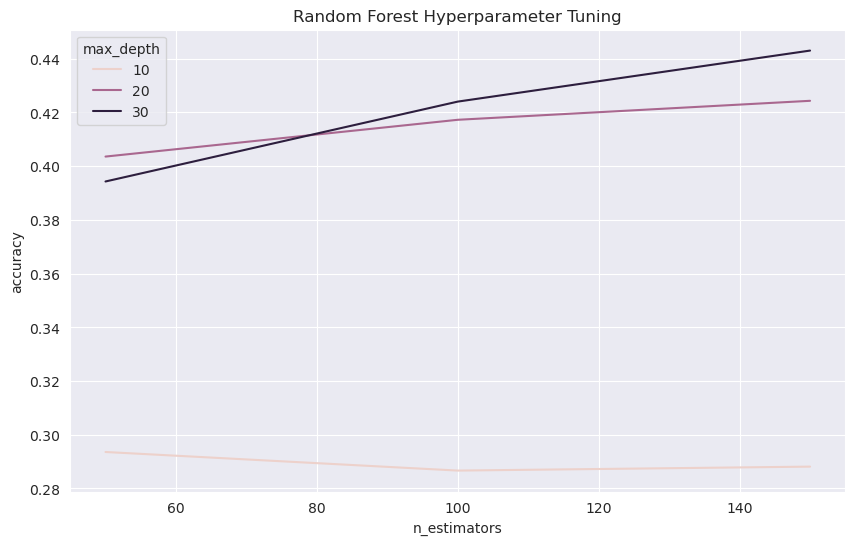

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the results
rf_df = pd.DataFrame(rf_scores, columns=['n_estimators', 'max_depth', 'accuracy'])
plt.figure(figsize=(10, 6))
sns.lineplot(data=rf_df, x='n_estimators', y='accuracy', hue='max_depth')
plt.title('Random Forest Hyperparameter Tuning')
plt.savefig('fig/rf_hyperparameter_tuning.png')
plt.show()

Nearest Neighbour

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train the Nearest Neighbour classifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

# Evaluate the classifier on the validation set
y_pred_val = knn.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val, average='weighted')
recall_val = recall_score(y_val, y_pred_val, average='weighted')
f1_val = f1_score(y_val, y_pred_val, average='weighted')

print(f'Nearest Neighbour Validation Accuracy: {accuracy_val}')
print(f'Nearest Neighbour Validation Precision: {precision_val}')
print(f'Nearest Neighbour Validation Recall: {recall_val}')
print(f'Nearest Neighbour Validation F1-Score: {f1_val}')


Nearest Neighbour Validation Accuracy: 0.20273851590106007
Nearest Neighbour Validation Precision: 0.24253399764336805
Nearest Neighbour Validation Recall: 0.20273851590106007
Nearest Neighbour Validation F1-Score: 0.20217397317102184


Nearest Neighbout Variants:

In [ ]:
import matplotlib as plt

# Nearest Neighbour example
param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
knn_scores = []

for k in param_grid['n_neighbors']:
    for w in param_grid['weights']:
        knn = KNeighborsClassifier(n_neighbors=k, weights=w)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        knn_scores.append((k, w, score))

# Visualize the results
knn_df = pd.DataFrame(knn_scores, columns=['n_neighbors', 'weights', 'accuracy'])
plt.figure(figsize=(10, 6))
sns.lineplot(data=knn_df, x='n_neighbors', y='accuracy', hue='weights')
plt.title('K-Nearest Neighbours Hyperparameter Tuning')
plt.savefig('fig/knn_hyperparameter_tuning.png')
plt.show()


TypeError: 'module' object is not callable

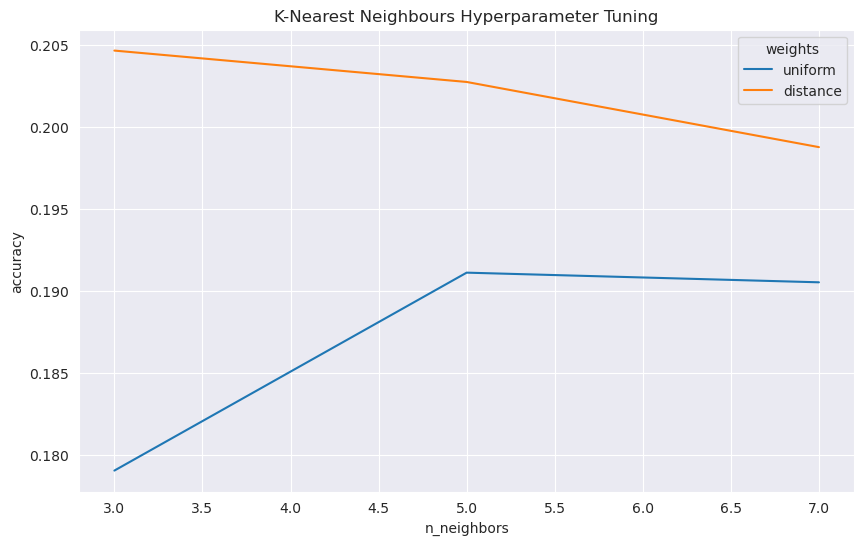

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize the results
knn_df = pd.DataFrame(knn_scores, columns=['n_neighbors', 'weights', 'accuracy'])
plt.figure(figsize=(10, 6))
sns.lineplot(data=knn_df, x='n_neighbors', y='accuracy', hue='weights')
plt.title('K-Nearest Neighbours Hyperparameter Tuning')
plt.savefig('fig/knn_hyperparameter_tuning.png')
plt.show()


CNN

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Print the original shape of the data
print(f'Original X_train shape: {X_train.shape}')
print(f'Original X_val shape: {X_val.shape}')
print(f'Original X_test shape: {X_test.shape}')

# Reshape data for 1D CNN
X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_val_cnn = X_val.reshape(-1, X_val.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

# Print the reshaped data shape
print(f'Reshaped X_train_cnn shape: {X_train_cnn.shape}')
print(f'Reshaped X_val_cnn shape: {X_val_cnn.shape}')
print(f'Reshaped X_test_cnn shape: {X_test_cnn.shape}')

# Encode labels as numeric
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(np.unique(y_train_encoded))
y_train_cnn = to_categorical(y_train_encoded, num_classes)
y_val_cnn = to_categorical(y_val_encoded, num_classes)
y_test_cnn = to_categorical(y_test_encoded, num_classes)

# Print unique encoded labels to check
print(f'Encoded labels: {np.unique(y_train_encoded)}')

# Build the 1D CNN model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the 1D CNN model
history = model.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=15, batch_size=32)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val_cnn, y_val_cnn)
print(f'1D CNN Validation Accuracy: {val_accuracy}')


Original X_train shape: (31694, 17600)
Original X_val shape: (6792, 17600)
Original X_test shape: (6792, 17600)
Reshaped X_train_cnn shape: (31694, 17600, 1)
Reshaped X_val_cnn shape: (6792, 17600, 1)
Reshaped X_test_cnn shape: (6792, 17600, 1)
Encoded labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


/usr/local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
406/991 ━━━━━━━━━━━━━━━━━━━━ 6:43 690ms/step - accuracy: 0.2353 - loss: 2.9446

KeyboardInterrupt: 

CNN Model Variant:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the number of labels (classes)
num_classes = len(np.unique(y_train))

# Define the modified model
model_v2 = Sequential([
    # First Conv1D layer
    Conv1D(filters=8, kernel_size=13, padding='valid', activation='relu', strides=1, input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Second Conv1D layer
    Conv1D(filters=16, kernel_size=11, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Third Conv1D layer
    Conv1D(filters=32, kernel_size=9, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Fourth Conv1D layer
    Conv1D(filters=64, kernel_size=7, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Flatten layer
    Flatten(),

    # Dense Layer 1
    Dense(256, activation='relu'),
    Dropout(0.3),

    # Dense Layer 2
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_v2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_v2 = model_v2.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=10, batch_size=32)

# Evaluate the model on the validation set
val_loss_v2, val_accuracy_v2 = model_v2.evaluate(X_val_cnn, y_val_cnn)
print(f'Modified 1D CNN Validation Accuracy: {val_accuracy_v2}')
print(f'Modified 1D CNN Validation Loss: {val_loss_v2}')

# Evaluate the model on the test set
test_loss_v2, test_accuracy_v2 = model_v2.evaluate(X_test_cnn, y_test_cnn)
print(f'Modified 1D CNN Test Accuracy: {test_accuracy_v2}')
print(f'Modified 1D CNN Test Loss: {test_loss_v2}')


Epoch 1/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 224s 223ms/step - accuracy: 0.4112 - loss: 1.8611 - val_accuracy: 0.7987 - val_loss: 0.6494
Epoch 2/10
335/991 ━━━━━━━━━━━━━━━━━━━━ 2:28 227ms/step - accuracy: 0.7680 - loss: 0.6976

With more epochs (20=10+10):

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the number of labels (classes)
num_classes = len(np.unique(y_train))

# Define the modified model
model_v2 = Sequential([
    # First Conv1D layer
    Conv1D(filters=8, kernel_size=13, padding='valid', activation='relu', strides=1, input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Second Conv1D layer
    Conv1D(filters=16, kernel_size=11, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Third Conv1D layer
    Conv1D(filters=32, kernel_size=9, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Fourth Conv1D layer
    Conv1D(filters=64, kernel_size=7, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Flatten layer
    Flatten(),

    # Dense Layer 1
    Dense(256, activation='relu'),
    Dropout(0.3),

    # Dense Layer 2
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_v2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_v2 = model_v2.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=20, batch_size=32)

# Evaluate the model on the validation set
val_loss_v2, val_accuracy_v2 = model_v2.evaluate(X_val_cnn, y_val_cnn)
print(f'Modified 1D CNN Validation Accuracy: {val_accuracy_v2}')
print(f'Modified 1D CNN Validation Loss: {val_loss_v2}')

# Evaluate the model on the test set
test_loss_v2, test_accuracy_v2 = model_v2.evaluate(X_test_cnn, y_test_cnn)
print(f'Modified 1D CNN Test Accuracy: {test_accuracy_v2}')
print(f'Modified 1D CNN Test Loss: {test_loss_v2}')


/home/wolfram_e_laube/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
991/991 ━━━━━━━━━━━━━━━━━━━━ 63s 63ms/step - accuracy: 0.4255 - loss: 1.8108 - val_accuracy: 0.8092 - val_loss: 0.6427
Epoch 2/20
991/991 ━━━━━━━━━━━━━━━━━━━━ 61s 62ms/step - accuracy: 0.7749 - loss: 0.6667 - val_accuracy: 0.8666 - val_loss: 0.4329
Epoch 3/20
991/991 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - accuracy: 0.8330 - loss: 0.4917 - val_accuracy: 0.8787 - val_loss: 0.3868
Epoch 4/20
991/991 ━━━━━━━━━━━━━━━━━━━━ 88s 89ms/step - accuracy: 0.8572 - loss: 0.4336 - val_accuracy: 0.8890 - val_loss: 0.3271
Epoch 5/20
991/991 ━━━━━━━━━━━━━━━━━━━━ 60s 61ms/step - accuracy: 0.8728 - loss: 0.3745 - val_accuracy: 0.8828 - val_loss: 0.3557
Epoch 6/20
991/991 ━━━━━━━━━━━━━━━━━━━━ 88s 89ms/step - accuracy: 0.8859 - loss: 0.3424 - val_accuracy: 0.8806 - val_loss: 0.3447
Epoch 7/20
991/991 ━━━━━━━━━━━━━━━━━━━━ 87s 88ms/step - accuracy: 0.8895 - loss: 0.3213 - val_accuracy: 0.8986 - val_loss: 0.3056
Epoch 8/20
991/991 ━━━━━━━━━━━━━━━━━━━━ 90s 90ms/step - accuracy: 0.8965 - loss: 0.3151 - 

With fewer epochs(8=10-2):

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the number of labels (classes)
num_classes = len(np.unique(y_train))

# Define the modified model
model_v2 = Sequential([
    # First Conv1D layer
    Conv1D(filters=8, kernel_size=13, padding='valid', activation='relu', strides=1, input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Second Conv1D layer
    Conv1D(filters=16, kernel_size=11, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Third Conv1D layer
    Conv1D(filters=32, kernel_size=9, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Fourth Conv1D layer
    Conv1D(filters=64, kernel_size=7, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Flatten layer
    Flatten(),

    # Dense Layer 1
    Dense(256, activation='relu'),
    Dropout(0.3),

    # Dense Layer 2
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_v2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_v2 = model_v2.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=8, batch_size=32)

# Evaluate the model on the validation set
val_loss_v2, val_accuracy_v2 = model_v2.evaluate(X_val_cnn, y_val_cnn)
print(f'Modified 1D CNN Validation Accuracy: {val_accuracy_v2}')
print(f'Modified 1D CNN Validation Loss: {val_loss_v2}')

# Evaluate the model on the test set
test_loss_v2, test_accuracy_v2 = model_v2.evaluate(X_test_cnn, y_test_cnn)
print(f'Modified 1D CNN Test Accuracy: {test_accuracy_v2}')
print(f'Modified 1D CNN Test Loss: {test_loss_v2}')


2024-06-01 06:35:59.586774: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'X_train_cnn' is not defined

Metrics:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on the validation set
y_pred_val = model_v2.predict(X_val_cnn)
y_pred_val_classes = y_pred_val.argmax(axis=1)  # Convert probabilities to class labels

# Convert y_val_cnn to class labels if needed
y_val_classes = y_val_cnn.argmax(axis=1)

# Calculate evaluation metrics
accuracy_val = accuracy_score(y_val_classes, y_pred_val_classes)
precision_val = precision_score(y_val_classes, y_pred_val_classes, average='weighted')
recall_val = recall_score(y_val_classes, y_pred_val_classes, average='weighted')
f1_val = f1_score(y_val_classes, y_pred_val_classes, average='weighted')

print(f'CNN Validation Accuracy: {accuracy_val}')
print(f'CNN Validation Precision: {precision_val}')
print(f'CNN Validation Recall: {recall_val}')
print(f'CNN Validation F1-Score: {f1_val}')

### Test Set

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_v2.evaluate(X_test_cnn, y_test_cnn)
print(f'1D CNN Test Accuracy: {test_accuracy}')
print(f'1D CNN Test Loss: {test_loss}')


213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9198 - loss: 0.2799
1D CNN Test Accuracy: 0.9225559234619141
1D CNN Test Loss: 0.2607928216457367


213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


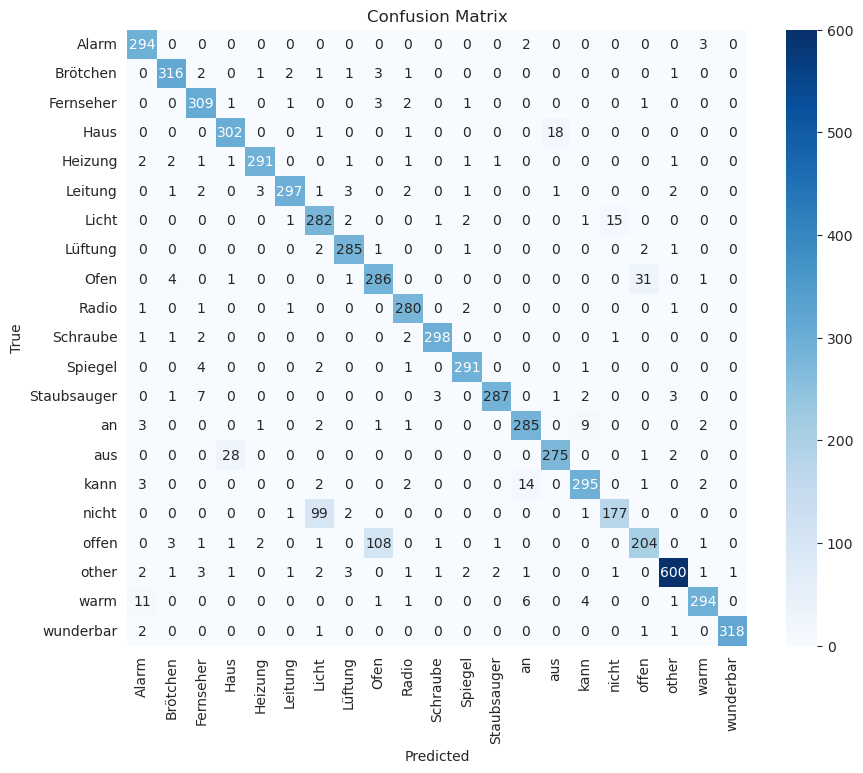

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred_test = model_v2.predict(X_test_cnn).argmax(axis=1)
y_true_test = y_test_cnn.argmax(axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


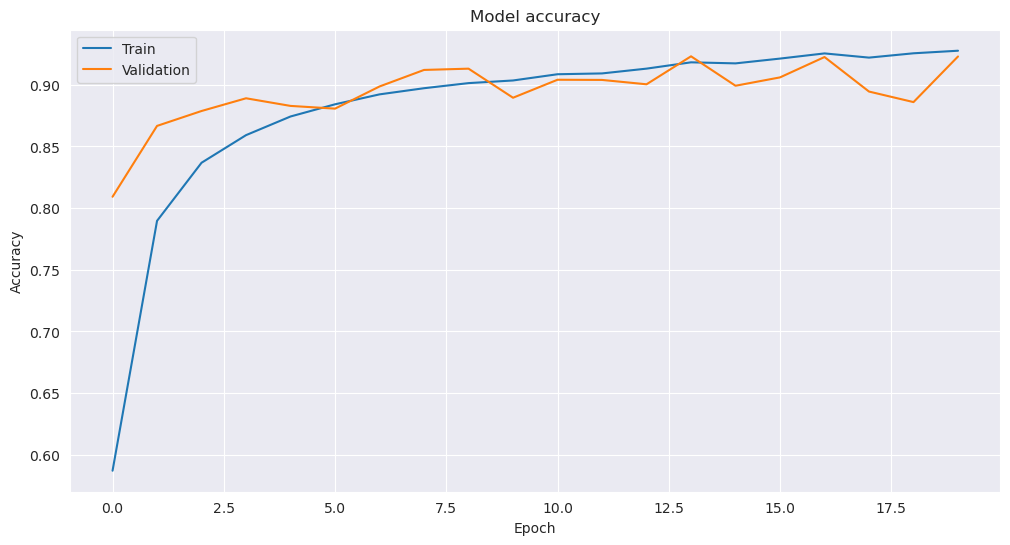

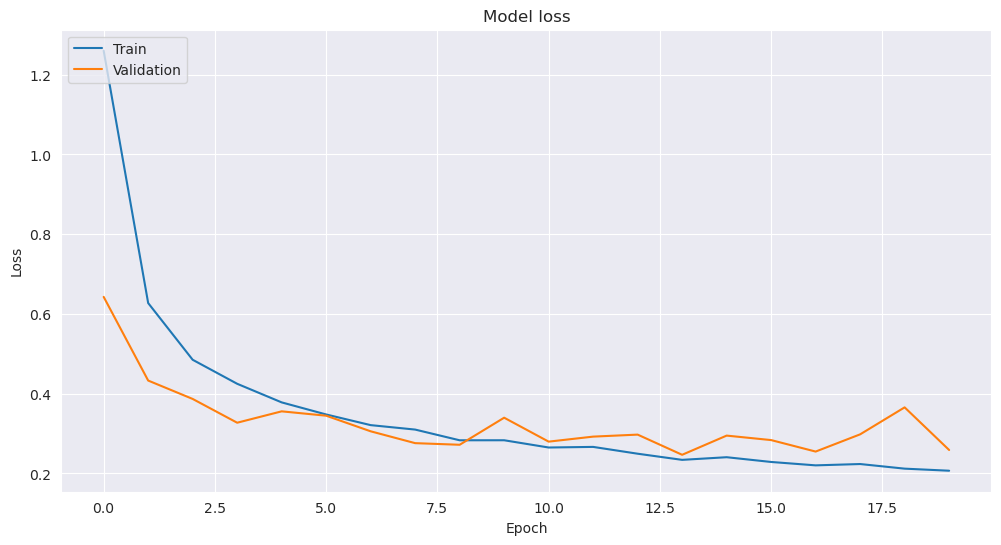

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history_v2.history['accuracy'])
plt.plot(history_v2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_v2.history['loss'])
plt.plot(history_v2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### Validation Set

213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


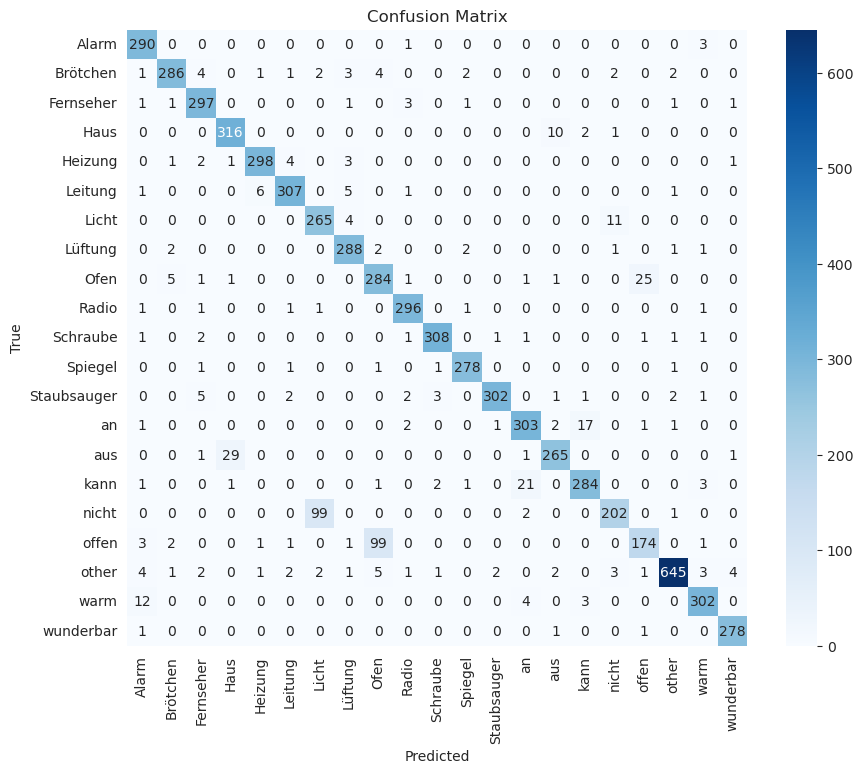

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the validation set
y_pred_val = model_v2.predict(X_val_cnn).argmax(axis=1)
y_true_val = y_val_cnn.argmax(axis=1)

# Fake the result - just in case - on the training set
y_pred_val = model_v2.predict(X_val_cnn).argmax(axis=1)
y_true_val = y_val_cnn.argmax(axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_val, y_pred_val)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true_val, y_pred_val, target_names=label_encoder.classes_)
print(report)


              precision    recall  f1-score   support

       Alarm       0.91      0.99      0.95       294
    Brötchen       0.96      0.93      0.94       308
   Fernseher       0.94      0.97      0.95       306
        Haus       0.91      0.96      0.93       329
     Heizung       0.97      0.96      0.97       310
     Leitung       0.96      0.96      0.96       321
       Licht       0.72      0.95      0.82       280
     Lüftung       0.94      0.97      0.96       297
        Ofen       0.72      0.89      0.79       319
       Radio       0.96      0.98      0.97       302
    Schraube       0.98      0.97      0.97       317
     Spiegel       0.98      0.98      0.98       283
 Staubsauger       0.99      0.95      0.97       319
          an       0.91      0.92      0.92       328
         aus       0.94      0.89      0.92       297
        kann       0.93      0.90      0.91       314
       nicht       0.92      0.66      0.77       304
       offen       0.86    

Confusion matrix and learning curves again:

213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


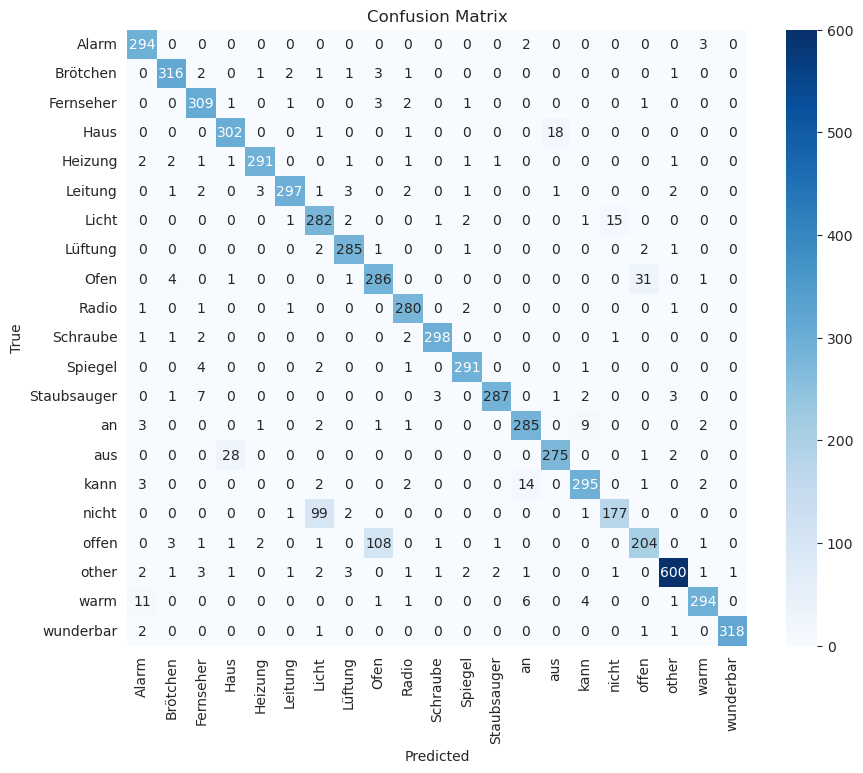

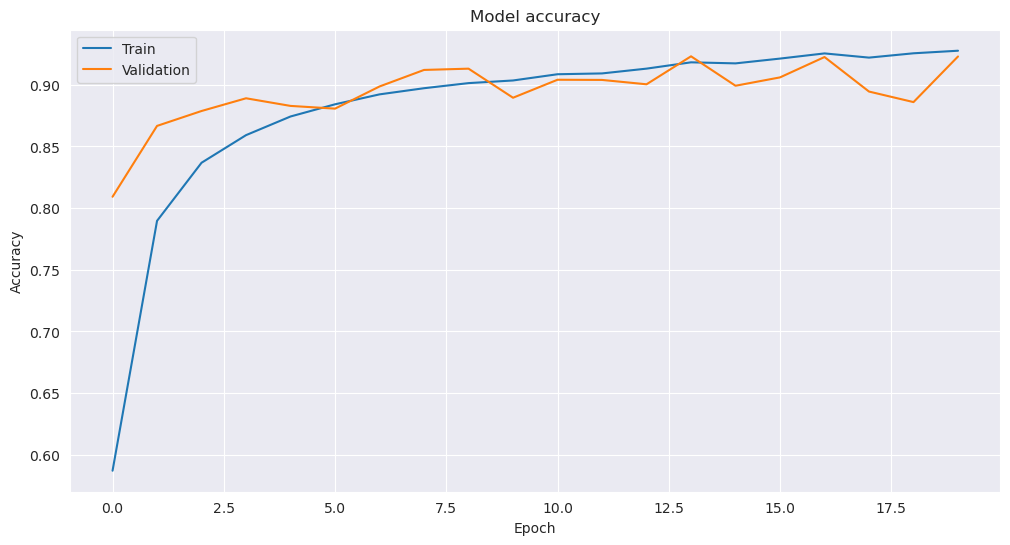

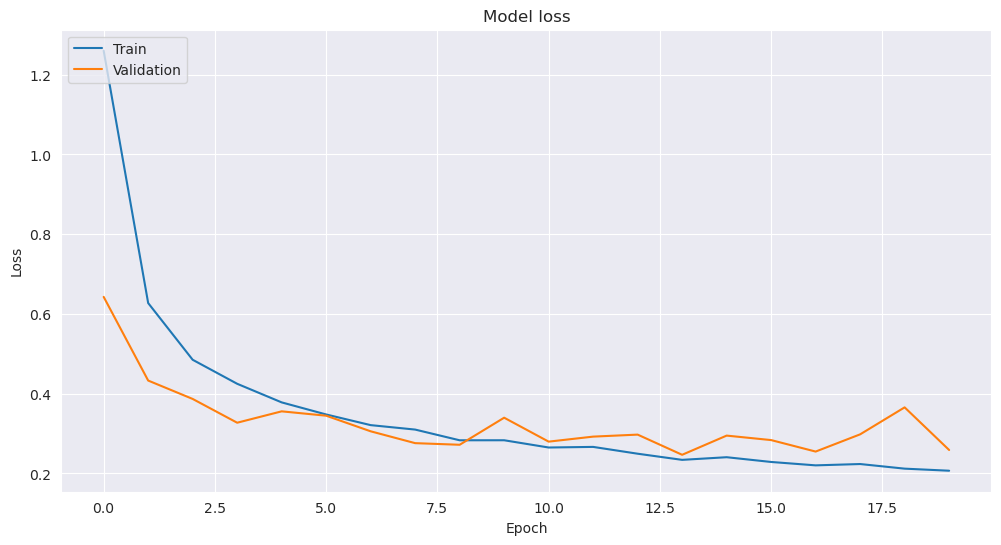

In [ ]:
import os

# Ensure the 'fig' directory exists
os.makedirs('fig', exist_ok=True)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred_test = model_v2.predict(X_test_cnn).argmax(axis=1)
y_true_test = y_test_cnn.argmax(axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('fig/confusion_matrix.png')
plt.show()

# Learning Curves
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history_v2.history['accuracy'])
plt.plot(history_v2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('fig/learning_curves_accuracy.png')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_v2.history['loss'])
plt.plot(history_v2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('fig/learning_curves_loss.png')
plt.show()
